In [39]:
from data.custom import CustomTrain, CustomTest
from models.vqgan import VQMultiModel
from data.utils import custom_collate
import torch

model = VQMultiModel.load_from_checkpoint("/shared/imagenet/vqgan_multi_9_logs/last.ckpt")
model.to("cuda")
model.eval()

dataset = CustomTrain(
            training_images_list_file="/shared/imagenet/train.txt",
            size=256
        )

img = custom_collate([dataset[1]])

print(img['image'].shape)


Working with z of shape (1, 1280, 32, 32) = 1310720 dimensions.
Working with z of shape (1, 1024, 16, 16) = 262144 dimensions.
Working with z of shape (1, 768, 8, 8) = 49152 dimensions.
Working with z of shape (1, 512, 4, 4) = 8192 dimensions.
Working with z of shape (1, 256, 2, 2) = 1024 dimensions.


/home/spruce/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/spruce/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/spruce/ndp/modules/losses/lpips.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-mo

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
torch.Size([1, 256, 256, 3])


In [47]:
x = model.get_input(custom_collate([dataset[0], dataset[1], dataset[2], dataset[3], dataset[4]]), model.image_key)

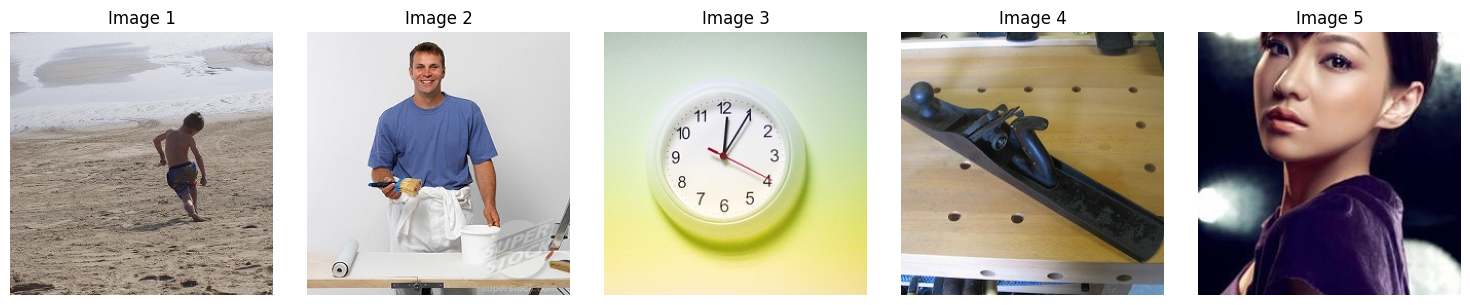

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    # Convert tensor to image format and move to CPU 
    img = x[i].permute(1,2,0).cpu().numpy()
    # Clip values to valid range
    img = (img * 0.5 + 0.5).clip(0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image {i+1}')

plt.tight_layout()
plt.show()

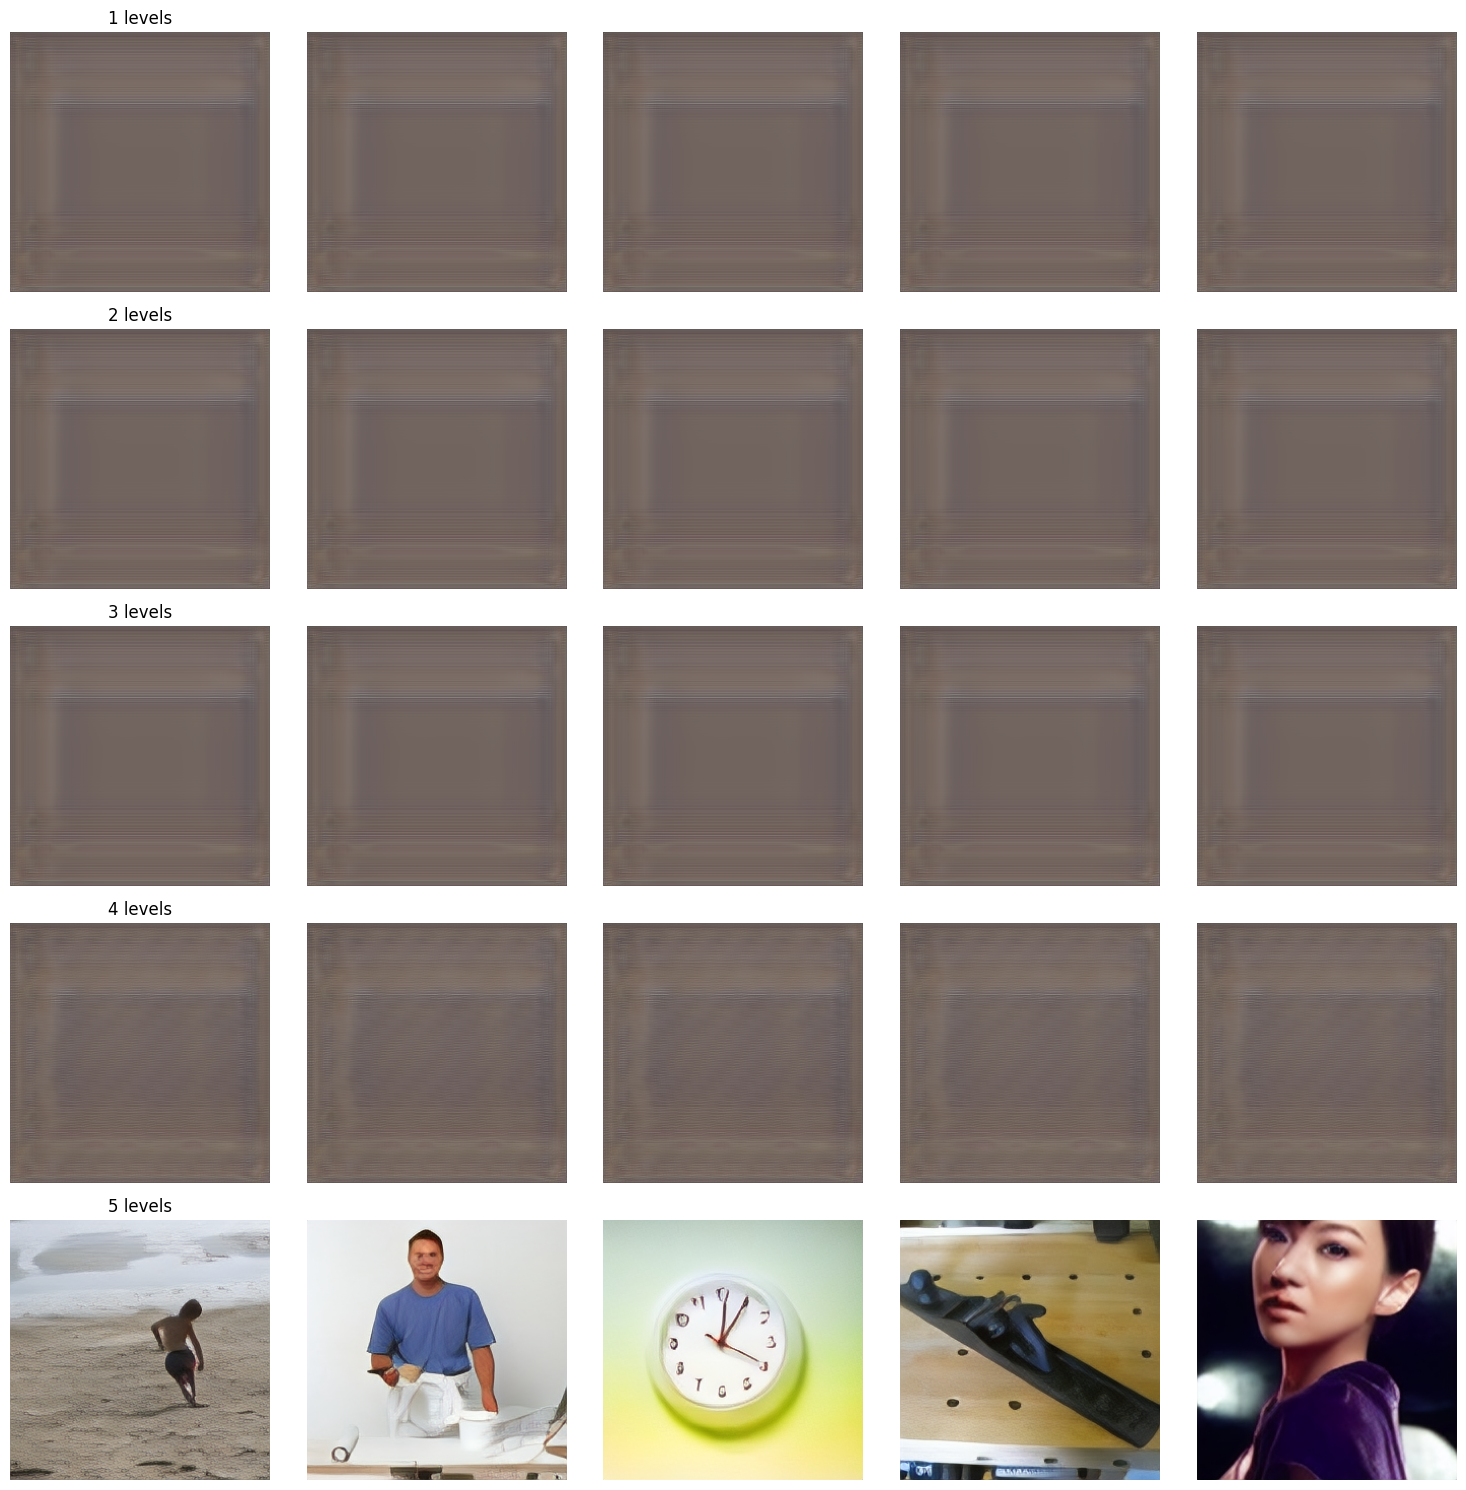

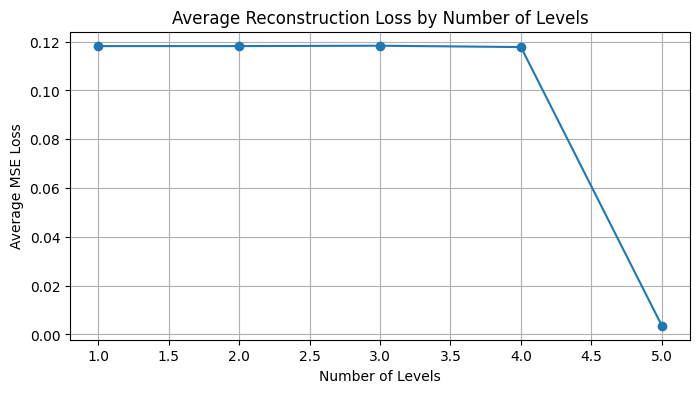

In [58]:
import numpy as np
with torch.no_grad():
    _, _, _, _, _, diff, info = model.encode(x.to("cuda"))
    (_, _, info1), (_, _, info2), (_, _, info3), (_, _, info4), (_, _, info5) = info
    
    quant1 = model.quantize_1.get_codebook_entry(info1, (5, 32, 32, 8))
    quant2 = model.quantize_2.get_codebook_entry(info2, (5, 16, 16, 8))
    quant3 = model.quantize_3.get_codebook_entry(info3, (5, 8, 8, 8))
    quant4 = model.quantize_4.get_codebook_entry(info4, (5, 4, 4, 8))
    quant5 = model.quantize_5.get_codebook_entry(info5, (5, 2, 2, 8))
    
    zero1 = model.quantize_1.get_codebook_entry(torch.zeros_like(info1), (5, 32, 32, 8))
    zero2 = model.quantize_2.get_codebook_entry(torch.zeros_like(info2), (5, 16, 16, 8))
    zero3 = model.quantize_3.get_codebook_entry(torch.zeros_like(info3), (5, 8, 8, 8))
    zero4 = model.quantize_4.get_codebook_entry(torch.zeros_like(info4), (5, 4, 4, 8))
    zero5 = model.quantize_5.get_codebook_entry(torch.zeros_like(info5), (5, 2, 2, 8))
    
    # Generate reconstructions with progressively more tokens
    y1 = model.decode(zero1, zero2, zero3, zero4, quant5)
    y2 = model.decode(zero1, zero2, zero3, quant4, quant5)
    y3 = model.decode(zero1, zero2, quant3, quant4, quant5)
    y4 = model.decode(zero1, quant2, quant3, quant4, quant5)
    y5 = model.decode(quant1, zero2, zero3, zero4, quant5)

# Set up subplot grid
plt.figure(figsize=(15,15))
images = [y1, y2, y3, y4, y5]

for i, img in enumerate(images):
    for j in range(5):  # For each image in batch
        plt.subplot(5, 5, i*5 + j + 1)
        # Convert tensor to image format and move to CPU
        img_j = img[j].permute(1,2,0).cpu().numpy()
        # Clip values to valid range
        img_j = (img_j * 0.5 + 0.5).clip(0, 1)
        plt.imshow(img_j)
        plt.axis('off')
        if j == 0:  # Only show level labels for first column
            plt.title(f'{i+1} levels')

plt.tight_layout()
plt.show()

# Calculate average reconstruction loss (MSE) for each level
x_np = x.permute(0,2,3,1).cpu().numpy()
x_np = (x_np * 0.5 + 0.5).clip(0, 1)

avg_losses = []
for img in images:
    img_np = img.permute(0,2,3,1).cpu().numpy()
    img_np = (img_np * 0.5 + 0.5).clip(0, 1)
    mse = np.mean((x_np - img_np) ** 2)
    avg_losses.append(mse)

# Plot average losses
plt.figure(figsize=(8,4))
plt.plot(range(1,6), avg_losses, marker='o')
plt.xlabel('Number of Levels')
plt.ylabel('Average MSE Loss')
plt.title('Average Reconstruction Loss by Number of Levels')
plt.grid(True)
plt.show()
